# Schelling's Segregation Model with Matplotlib Inline Visualisation for Jupyter Notebooks

When using Matplotlib in this form, it is important to bear in mind that almost all errors generated by functions called by the interactive interface are masked / hidden, i.e. they will interupt the execution of the calling function concerned, but no error message will be visible. This makes debugging extremely difficult for the students! It is thus crucial to find a way to avoid this during development. One possibility to achieve this is to "layer" the development, i.e. to explicitly call the step() and draw() function from the command line (Jupyter cell) first without the interactive interface first (This will leave error messages visible). Only in the final step, when the update functions work, should the interactive interface be wrapped around everything.  

## Set up matplotlib interface

The alternative is to use TKAgg, in which case matplotlib will run in a separate window.
This can be a bit snappier.
Note, however, that the current way the animation is implemented via a timer does not work with TkAgg. Manual stepping works fine, but auto-stepping doesn't. Messing around with timed functions in Tkagg is a bit tricky, because the Tk main loop takes over and GUI functions can only be triggered from the main thread (see https://www.physics.utoronto.ca/~phy326/python/Live_Plot.py). The alternative, to use Matplotlib animation, does not work either, because it cannot be interrupted. 

_The next line must be commented out when the file is used via import into another notebook, but must be executed as code when this notebook is used standalone_

In [1]:
matplotlib nbagg  

The alternative is to use TKAgg, in which case matplotlib will run in a separate window.
This can be a bit snappier.
Note, however, that the current way the animation is implemented via a timer does not work with TkAgg. Manual stepping works fine, but auto-stepping doesn't. Messing around with timed functions in Tkagg is a bit tricky, because the Tk main loop takes over and GUI functions can only be triggered from the main thread (see https://www.physics.utoronto.ca/~phy326/python/Live_Plot.py). 

The alternative, to use Matplotlib animation, does not work either, because it cannot be interrupted. 

** Note ** For development I definitely recommend toi use TKAgg, becuase nbagg will swallow all error messages, so things will simply not happen but nobody will be any wiser as to why! This could also be a problem with the students if they modify code. Maybe use nbagg for application-modulkes and TKAgg for BTS modules.

** Do not !!! execute the next line first if you want to use nbagg **

** If you want to use it you need to uncomment the code first **

In [2]:
#import matplotlib
#matplotlib.use('TKAgg')

## General Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.cm as cm

import random as RD
import scipy as SP

import time, threading

C:\Users\gauta\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The actual simulation code

In [4]:
def simulation(density, threshold):
    global config, fig, ax, bnext, bstart, bstop, binit, empty, unhappiness, avg_similarity
    # apparently the buttons need to be declared as global to avoid 
    # that they are garbage-collected. If this happens they will still be visible but become inactive

    def stopAnim(d):
        global stop
        stop=True

    def startAnim(d):
        global stop
        stop=False
        foo()

    def advance(d):
        global mat, config, plt, time
        time += 1
        step(threshold)
        mat.set_data(config)
        plt.title('t = ' + str(time))    
        plt.show()

    def initAnim(d):
        global mat, config, plt, time
        time = 0
        init(density)
        mat = ax.matshow(config, cmap=cm.seismic)
        mat.set_data(config)
        plt.title('t = ' + str(time))    
        plt.show()    

    def updateSpeed(val):
        global speed
        speed = 1/sspeed.val

    def foo():
        global speed, timer, stop
        advance(None)
        if not(stop):
            timer=threading.Timer(speed, foo)
            timer.start()

    
    RD.seed()
    fig, ax = plt.subplots()
    ax.axis('off')
    plt.title("Shelling's Segregation Model")

    axspeed = plt.axes([0.175, 0.05, 0.65, 0.03])
    sspeed = Slider(axspeed, 'Speed', 0.1, 10.0, valinit=1.0)
    sspeed.on_changed(updateSpeed)

    axnext = plt.axes([0.85, 0.15, 0.1, 0.075])
    axstart = plt.axes([0.85, 0.25, 0.1, 0.075])
    axstop = plt.axes([0.85, 0.35, 0.1, 0.075])
    axinit = plt.axes([0.85, 0.45, 0.1, 0.075])
    bnext = Button(axnext, 'Next')
    bnext.on_clicked(advance)
    bstart = Button(axstart, 'Start')
    bstart.on_clicked(startAnim)
    bstop = Button(axstop, 'Stop')
    bstop.on_clicked(stopAnim)
    binit = Button(axinit, 'Init')
    binit.on_clicked(initAnim)
    config = SP.zeros([height, width])
    initAnim(None)
    updateSpeed(None)

    #ani = animation.FuncAnimation(fig, advance, frames=99, interval=60, save_count=50, repeat=False)
    #plt.show()

### Define the initialisation of the state

In [5]:
def init(density):
    global config, empty, agents, unhappiness, avg_similarity
    empty =[]
    agents=[]
    unhappiness=[]
    avg_similarity=[]
    config = SP.zeros([height, width])
    for x in range(width):
        for y in range(height):
            if RD.random() < density:
                agents.append((y, x))
                if RD.random() < 0.5:
                    config[y, x] = 1
                else:
                    config[y, x] = -1
            else:
                config[y,x] = 0
                empty.append((y, x))


### Define the state transition rules

In [6]:
def step(threshold):
    global config, agents, empty, unhappiness, avg_similarity

    unhappy = 0
    similarity = 0.0

    height, width = config.shape

    sequence = list(range(len(agents)))
    RD.shuffle(sequence)
    for i in sequence:
        agent = agents[i]
        y, x = agent
        state = config[y, x]
        if state == 0:
            continue
        similar = 0
        total = 0
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if not ((dx == 0) and (dy == 0)):
                    v = config[(y + dy)%height, (x+dx)%width]
                    if (v != 0):
                        total += 1
                    if (v == state):
                        similar += 1
        if (total == 0):
            similarity += 1
        else:
            similarity += similar / (1.0*total)
        if (similar < threshold * total):
            unhappy += 1
            newpos = RD.randrange(len(empty))
            new_y, new_x = empty[newpos]
            config[new_y, new_x] = state
            agents[i] = empty[newpos]
            config[y, x] = 0
            empty[newpos] = agent
    percent_unhappy_now = unhappy / (1.0*len(agents)) # of all agents
    avg_similarity_now = similarity / (1.0*len(agents)) # avg across all agents
    unhappiness = unhappiness+[percent_unhappy_now]
    avg_similarity = avg_similarity+[avg_similarity_now]

# Auxiliary Functions for Plotting Results

In [7]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

import numpy as np
import scipy
from scipy import stats 
from IPython.display import clear_output

In [8]:
plotly.offline.init_notebook_mode(connected=True)

In [9]:
def plot_schelling():
    global unhappiness, avg_similarity
    n = len(unhappiness)
    trace1 = go.Scatter(
        x=list(range(n)), 
        y=unhappiness, 
        mode = 'lines+markers',
        name='average unhappiness'
    )
    trace2 = go.Scatter(
        x=list(range(n)), 
        y=avg_similarity, 
        mode = 'lines+markers',
        name='average similarity'
    )
    data = [trace1, trace2]
    return iplot(data)


### Set the simulation parameters

In [10]:
width = 50
height = 50

density =0.8
threshold =0.7

In [11]:
unhappiness=[]
avg_similarity=[]

# Testing

**comment these lines out if the file is imported into another file**

<IPython.core.display.Javascript object>


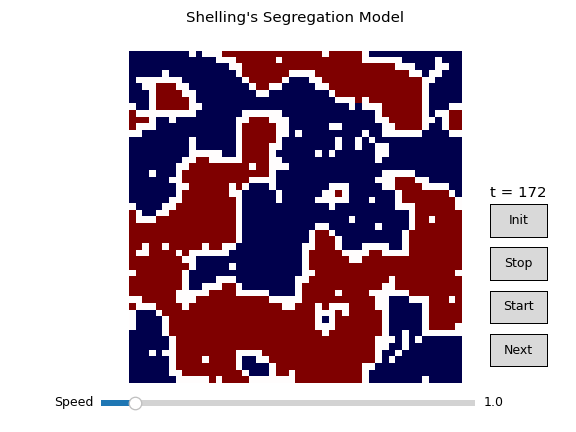

C:\Users\gauta\AppData\Local\Temp\ipykernel_31776\686966750.py:65: DeprecationWarning:

scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead

C:\Users\gauta\AppData\Local\Temp\ipykernel_31776\2125043357.py:7: DeprecationWarning:

scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead



In [12]:
simulation(density,threshold)

In [13]:
plot_schelling()

## Revised Version with Continuous Happiness Function

In [14]:
def happiness(similarity):
    global threshold
    if similarity<threshold:
        return 0
    else:
        return 1

In [15]:
def simulation_revised(density, h_fun):
    global config, fig, ax, bnext, bstart, bstop, binit, empty, unhappiness, avg_similarity
    # apparently the buttons need to be declared as global to avoid 
    # that they are garbage-collected. If this happens they will still be visible but become inactive

    def stopAnim(d):
        global stop
        stop=True

    def startAnim(d):
        global stop
        stop=False
        foo()

    def advance(d):
        global mat, config, plt, time
        time += 1
        step_revised(h_fun)
        mat.set_data(config)
        plt.title('t = ' + str(time))    
        plt.show()

    def initAnim(d):
        global mat, config, plt, time
        time = 0
        init(density)
        mat = ax.matshow(config, cmap=cm.seismic)
        mat.set_data(config)
        plt.title('t = ' + str(time))    
        plt.show()    

    def updateSpeed(val):
        global speed
        speed = 1/sspeed.val

    def foo():
        global speed, timer, stop
        advance(None)
        if not(stop):
            timer=threading.Timer(speed, foo)
            timer.start()

    
    RD.seed()
    fig, ax = plt.subplots()
    ax.axis('off')
    plt.title("Shelling's Segregation Model")

    axspeed = plt.axes([0.175, 0.05, 0.65, 0.03])
    sspeed = Slider(axspeed, 'Speed', 0.1, 10.0, valinit=1.0)
    sspeed.on_changed(updateSpeed)

    axnext = plt.axes([0.85, 0.15, 0.1, 0.075])
    axstart = plt.axes([0.85, 0.25, 0.1, 0.075])
    axstop = plt.axes([0.85, 0.35, 0.1, 0.075])
    axinit = plt.axes([0.85, 0.45, 0.1, 0.075])
    bnext = Button(axnext, 'Next')
    bnext.on_clicked(advance)
    bstart = Button(axstart, 'Start')
    bstart.on_clicked(startAnim)
    bstop = Button(axstop, 'Stop')
    bstop.on_clicked(stopAnim)
    binit = Button(axinit, 'Init')
    binit.on_clicked(initAnim)
    config = SP.zeros([height, width])
    initAnim(None)
    updateSpeed(None)

    #ani = animation.FuncAnimation(fig, advance, frames=99, interval=60, save_count=50, repeat=False)
    #plt.show()

In [16]:
def step_revised(h_fun):
    global config, agents, empty, unhappiness, avg_similarity

    unhappiness_now = 0
    similarity = 0.0

    height, width = config.shape

    sequence = list(range(len(agents)))
    RD.shuffle(sequence)
    for i in sequence:
        agent = agents[i]
        y, x = agent
        state = config[y, x]
        if state == 0:
            continue
        similar = 0
        total = 0
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                if not ((dx == 0) and (dy == 0)):
                    v = config[(y + dy)%height, (x+dx)%width]
                    if (v != 0):
                        total += 1
                    if (v == state):
                        similar += 1
        if (total == 0):
            similarity += 1
            unhappiness_now += 1-h_fun(1.0)
        else:
            similarity += similar / (1.0*total)
            unhappiness_now += 1-h_fun(similar/(1.0*total))
            if (RD.random() < 1-h_fun(similar/(1.0*total))): 
                newpos = RD.randrange(len(empty))
                new_y, new_x = empty[newpos]
                config[new_y, new_x] = state
                agents[i] = empty[newpos]
                config[y, x] = 0
                empty[newpos] = agent
    avg_similarity_now = similarity / (1.0*len(agents)) # avg across all agents
    unhappiness = unhappiness+[unhappiness_now/ (1.0*len(agents))]
    avg_similarity = avg_similarity+[avg_similarity_now]

<IPython.core.display.Javascript object>


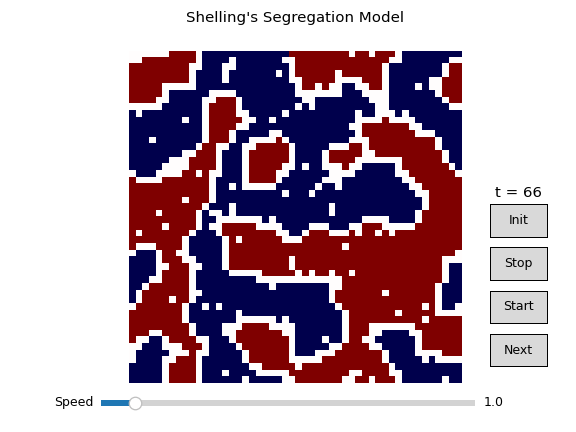

C:\Users\gauta\AppData\Local\Temp\ipykernel_31776\3442760454.py:65: DeprecationWarning:

scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead

C:\Users\gauta\AppData\Local\Temp\ipykernel_31776\2125043357.py:7: DeprecationWarning:

scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead



In [19]:
simulation_revised(density,happiness)

In [20]:
plot_schelling()